In [ ]:
!pip install polygon-api-client
!pip install requests
!pip install pandas
!pip install tqdm
!pip install mplfinance
!pip install tensorflow
!pip install numpy
!pip install matplotlib
!pip install scikit-learn
!pip install fastparquet

     |████████████████████████████████| 51kB 1.6MB/s 


In [ ]:
import os
import calendar
from datetime import datetime, timedelta

from polygon import RESTClient
import requests
import pandas as pd
from tqdm.notebook import tqdm
import mplfinance as mpf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# 1. Load Data

In [ ]:
def get(path, params={}):
    session = requests.Session()
    url = 'https://api.polygon.io' + path
    params['apiKey'] = os.environ['POLYGON_API_KEY']
    resp = session.request('GET', url, params=params)
    resp.raise_for_status()
    return resp.json()

In [ ]:
def get_bars(from_date, to_date):
    if isinstance(from_date, datetime):
        from_date = datetime.strftime(from_date, '%Y-%m-%d')
    if isinstance(to_date, datetime):
        to_date = datetime.strftime(to_date, '%Y-%m-%d')
    return get('/v2/aggs/ticker/{}/range/{}/{}/{}/{}'.format('SBUX',
                                                             1,
                                                             'minute',
                                                             from_date,
                                                             to_date))['results']

In [ ]:
class TradingDay:
    def __init__(self, date):
        if isinstance(date, str):
            self.start = datetime.strptime(date, '%Y-%m-%d')
        if isinstance(date, datetime):
            self.start = date
        self.end = self.start + timedelta(days=1)
        #self.weekday = calendar.day_name[self.start.weekday()]
        self.bars = pd.DataFrame(columns=['timestamp',
                                          'volume',
                                          'open',
                                          'close',
                                          'high',
                                          'low',
                                          'num_trades'])
        for bar in get_bars(self.start, self.end):
            self.bars = self.bars.append({
                'timestamp': bar['t'],
                'volume': bar['v'],
                'open': bar['o'],
                'close': bar['c'],
                'high': bar['h'],
                'low': bar['l'],
                'num_trades': bar.get('n', 0)
            }, ignore_index=True)
        
class TradingYear:
    def __init__(self, year):
        self.days = [
            TradingDay(
                datetime.strptime(
                    '{}-2019'.format(str(day)), '%j-%Y'
                )
            ) for day in tqdm(range(1,366))
        ]
   
    def get_bars(self):
        return pd.concat([day.bars for day in self.days])

In [ ]:
!ls /content/drive

'My Drive'


In [ ]:
try:
    year_df = pd.read_parquet('/content/drive/My Drive/pbc/2019_year_df.parquet.gzip')
except FileNotFoundError as e:
    year_df = TradingYear(2019).get_bars()
    year_df.to_parquet('.data/2019_year_df.parquet.gzip',
                       compression='gzip')

In [ ]:
year_df['timestamp'] = pd.to_datetime(year_df['timestamp'], unit='ms')
year_df = year_df.set_index('timestamp')

In [ ]:
display(year_df)
display(year_df.describe())

,volume,open,close,high,low,num_trades
timestamp,,,,,,
2019-01-02 12:17:00,300.0,63.67,63.68,63.68,63.67,4.0
2019-01-02 12:21:00,487.0,63.50,63.53,63.53,63.50,5.0
2019-01-02 12:22:00,1949.0,63.50,63.50,63.50,63.47,8.0
2019-01-02 12:31:00,203.0,63.52,63.52,63.52,63.52,3.0
2019-01-02 12:34:00,238.0,63.55,63.55,63.55,63.55,4.0
...,...,...,...,...,...,...
2019-12-31 21:08:00,1091.0,87.92,87.92,87.92,87.92,9.0
2019-12-31 21:11:00,3420.0,88.00,87.92,88.00,87.92,8.0
2019-12-31 22:16:00,100.0,87.92,87.92,87.92,87.92,1.0


,volume,open,close,high,low,num_trades
count,2.111520e+05,211152.000000,211152.000000,211152.000000,211152.000000,211152.000000
mean,1.658427e+04,81.475973,81.475427,81.499094,81.452129,140.239069
std,3.850306e+04,9.400280,9.400139,9.402859,9.397668,138.590137
min,0.000000e+00,61.460000,61.460000,61.460000,61.395000,0.000000
25%,6.330000e+03,74.305000,74.307525,74.320000,74.295000,74.000000
50%,1.055050e+04,83.345000,83.345000,83.370000,83.320000,112.000000
75%,1.768200e+04,88.280000,88.280000,88.300000,88.255000,167.000000
max,4.503728e+06,99.710000,99.718400,99.720000,99.642400,7284.000000


<AxesSubplot:xlabel='timestamp'>

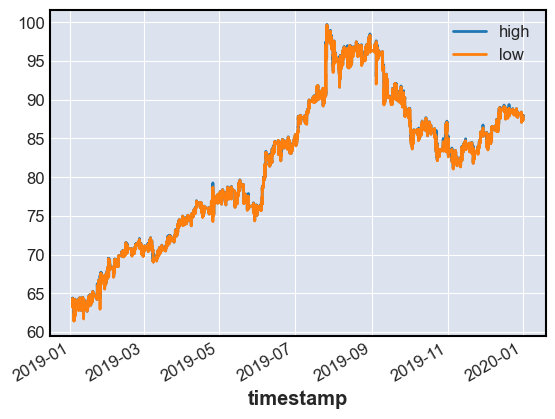

In [ ]:
year_df[['high', 'low']].plot()

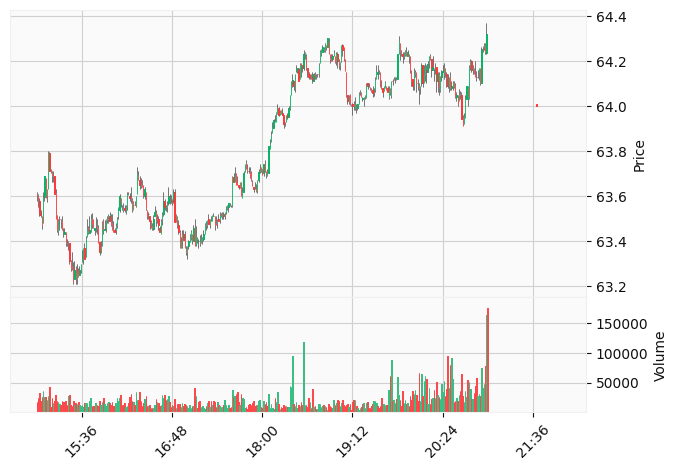

In [ ]:
mpf.plot(year_df.loc['2019-01-02 15:00':'2019-01-02 22:00',:], type='candle', volume=True, show_nontrading=True, style='yahoo')


# 2. Feature Engineering

In [ ]:
year_df.head()

,volume,open,close,high,low,num_trades
timestamp,,,,,,
2019-01-02 12:17:00,300.0,63.67,63.68,63.68,63.67,4.0
2019-01-02 12:21:00,487.0,63.50,63.53,63.53,63.50,5.0
2019-01-02 12:22:00,1949.0,63.50,63.50,63.50,63.47,8.0
2019-01-02 12:31:00,203.0,63.52,63.52,63.52,63.52,3.0
2019-01-02 12:34:00,238.0,63.55,63.55,63.55,63.55,4.0


In [ ]:
def passed_threshold(window):
    print(window)
    return True

year_df['high'].iloc[::-1].rolling(5).apply(passed_threshold).iloc[::-1]

# 3. Build the Model

# 4. Tuning

# 5. Analysis